In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, Input
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
# Load dataset
ds = load_dataset("Falah/Alzheimer_MRI")

train_dataset = ds['train']
test_dataset = ds['test']
train_images = train_dataset['image']
train_labels = train_dataset['label']
test_images = test_dataset['image']
test_labels = test_dataset['label']

In [5]:
# Print dataset information
print(f"Number of training images: {len(train_images)}")
print(f"Number of training labels: {len(train_labels)}")
print(f"Number of test images: {len(test_images)}")
print(f"Number of test labels: {len(test_labels)}")

Number of training images: 5120
Number of training labels: 5120
Number of test images: 1280
Number of test labels: 1280


In [7]:
# Normalize images
def normalize_image(image):
    image_np = np.array(image.resize((128, 128)).convert('L'))
    image_np = image_np / 255.0
    return image_np.reshape((128, 128, 1))

norm_train_images = np.array([normalize_image(img) for img in train_images])
norm_test_images = np.array([normalize_image(img) for img in test_images])

print(f"Train image shape: {norm_train_images[0].shape}")
print(f"Train image min pixel value: {norm_train_images[0].min()}, max pixel value: {norm_train_images[0].max()}")
print(f"Test image shape: {norm_test_images[0].shape}")
print(f"Test image min pixel value: {norm_test_images[0].min()}, max pixel value: {norm_test_images[0].max()}")

Train image shape: (128, 128, 1)
Train image min pixel value: 0.0, max pixel value: 0.615686274509804
Test image shape: (128, 128, 1)
Test image min pixel value: 0.0, max pixel value: 0.9882352941176471


In [9]:
# Convert lists to tensors
norm_train_images = tf.convert_to_tensor(norm_train_images, dtype=tf.float32)
norm_test_images = tf.convert_to_tensor(norm_test_images, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.int32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.int32)

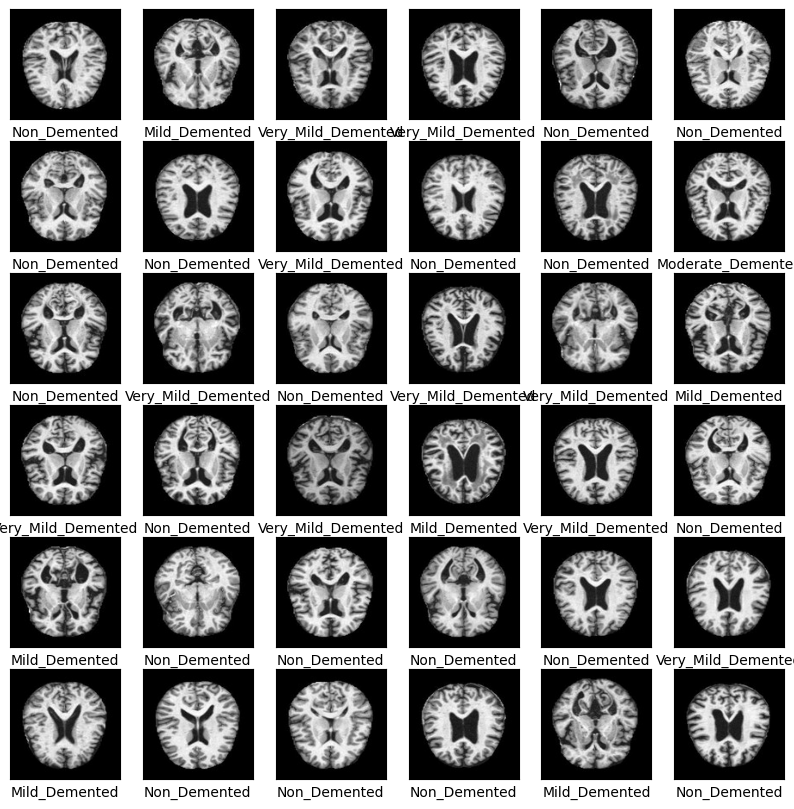

In [11]:
# Display sample images
class_names = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(norm_train_images[i].numpy().reshape(128, 128), cmap='gray')
    plt.xlabel(class_names[train_labels[i].numpy()])
plt.show()

In [13]:
# Build model
model = models.Sequential()
model.add(Input(shape=(128, 128, 1)))  # Define the input shape using Input layer
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4, activation='softmax')) 

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267,332 (12.46 MB)

 Trainable params: 3,267,332 (12.46 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [17]:
# Train model
batch_size = 32  # Set the batch size

history = model.fit(norm_train_images, train_labels, epochs=10, 
                    validation_data=(norm_test_images, test_labels),
                    batch_size=batch_size)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 56s 337ms/step - accuracy: 0.4700 - loss: 1.1118 - val_accuracy: 0.5984 - val_loss: 0.9438
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 60s 377ms/step - accuracy: 0.6131 - loss: 0.8486 - val_accuracy: 0.7266 - val_loss: 0.6532
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 64s 401ms/step - accuracy: 0.7765 - loss: 0.5299 - val_accuracy: 0.8367 - val_loss: 0.4146
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 61s 379ms/step - accuracy: 0.8998 - loss: 0.2604 - val_accuracy: 0.8867 - val_loss: 0.3028
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 55s 346ms/step - accuracy: 0.9721 - loss: 0.0964 - val_accuracy: 0.9531 - val_loss: 0.1305
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 41s 254ms/step - accuracy: 0.9932 - loss: 0.0293 - val_accuracy: 0.9633 - val_loss: 0.1138
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 41s 255ms/step - accuracy: 0.9992 - loss: 0.0121 - val_accuracy: 0.9570 - val_loss: 0.1392
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 42s 259ms/step - accuracy: 0.9956 - loss: 0

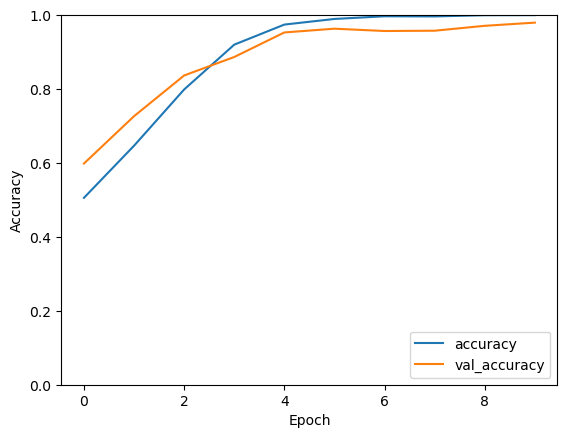

In [20]:
# Plot accuracy over epochs
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [22]:
# Evaluate model
test_loss, test_acc = model.evaluate(norm_test_images, test_labels, batch_size=batch_size, verbose=2)
print(f"Test accuracy: {test_acc}")

40/40 - 4s - 97ms/step - accuracy: 0.9797 - loss: 0.0992
Test accuracy: 0.979687511920929


In [24]:
# Predict the labels for the test set
predictions = model.predict(norm_test_images)
predicted_labels = np.argmax(predictions, axis=1)

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step


In [27]:
# Compute the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

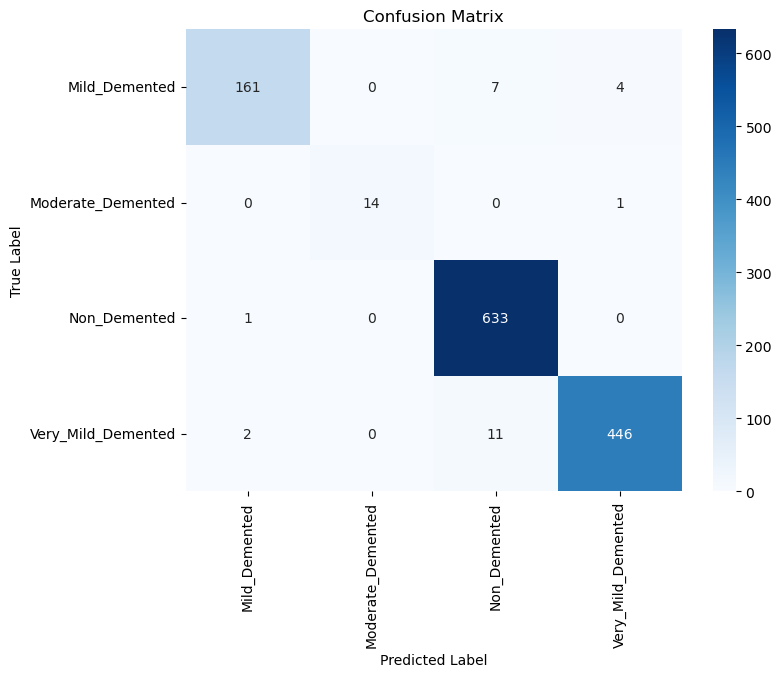

In [29]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()